In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
import joblib
import importlib
import machine_learning_02
importlib.reload(machine_learning_02)
from machine_learning_02 import data_load, data_split

# 모델 및 데이터 불러오기
model = joblib.load("../best_model.pkl")

data_df = data_load()

# 최고 스케일러 이름 작성 필요!
# scaler_nm => 'standard', 'minmax', 'maxabs', 'quantile', 'robust'
X_train, X_test, y_train, y_test = data_split(data_df, scaler_nm='standard')

# 예측
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

### 시각화 - ROC Curve

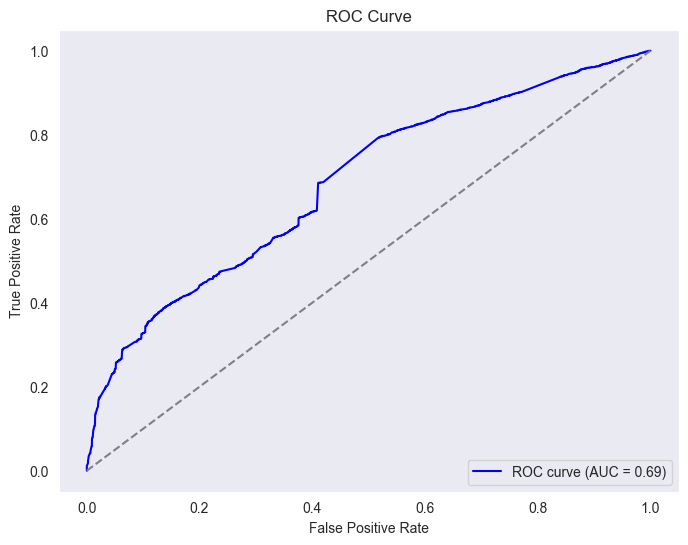

In [2]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.savefig('../images/ROC_Curve.png', dpi=300)
plt.show()

### 시각화 - Confusion Matrix Heatmap

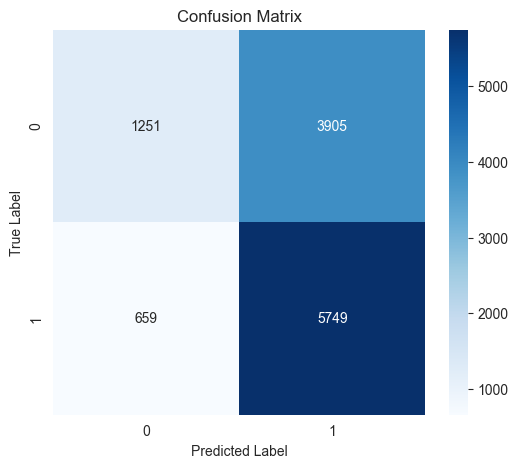

In [3]:
# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig('../images/Confusion_Matrix.png', dpi=300)
plt.show()

### 시각화 - Feature Importance Plot

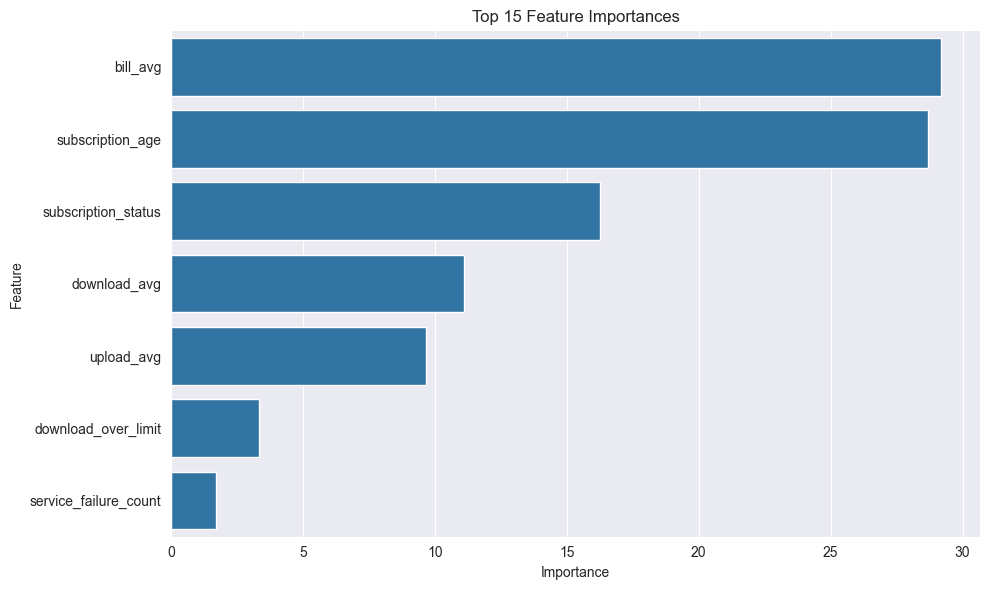

In [4]:
# Feature Importance Plot
if hasattr(model, "feature_importances_"):
    feature_importance = model.feature_importances_
    feature_names = X_test.columns
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": feature_importance
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=importance_df.head(15))
    plt.title("Top 15 Feature Importances")
    plt.tight_layout()
    plt.savefig('../images/Feature_Importances.png', dpi=300)
    plt.show()
else:
    print("This model does not support feature_importances_.")

#### ✅예측 vs 실제 가설 비교 요약
| 변수                            | 예측 인사이트            | 실제 분석 결과와 비교         | 결과 |
| ----------------------------- | ------------------ | -------------------- | -- |
| `is_tv_subscriber`            | TV 구독자는 덜 이탈할 것    | 중요도 낮음 → 영향 적음       | ❌  |
| `is_movie_package_subscriber` | 영화 패키지 구독자는 충성도 높음 | 중요도 낮음 → 큰 영향 없음     | ❌  |
| `subscription_age`            | 짧을수록 이탈 ↑          | 중요도 낮음 → 예측과 상반됨     | ❌  |
| `bill_avg`                    | 요금 높으면 이탈 ↑        | 중요도 낮음 → 유효하지 않음     | ❌  |
| `reamining_contract`          | 계약 남으면 이탈 ↓        | → 변수 미포함 (대체 변수 없음)  | -  |
| `service_failure_count`       | 서비스 실패 많을수록 이탈 ↑   | 중요도 매우 낮음 → 영향 미미    | ❌  |
| `download_avg`                | 많이 쓰는 유저 이탈 가능성 ↑  | 중요도 중간 → 유효한 예측      | ✅  |
| `upload_avg`                  | 활동 유저는 유지율 ↑       | 중요도 중간 → 유효한 해석 가능   | 🔄 |
| `download_over_limit`         | 추가 요금 부담 → 이탈 ↑    | 영향 낮음 → 큰 관련 없음      | ❌  |
| `subscription_status`         | 상태가 해지면 이탈 높음      | **가장 중요 변수** → 매우 유효 | ✅✅ |


---

#### 📌 종합 결론

* **핵심 변수**: 'subscription_status', 'is_tv_subscriber', 'download_avg', 'is_movie_package_subscriber'
* **모델 성능**: F1-score: 0.8599 / Accuracy: 0.8456 / ROC AUC: 0.9219
* **활용 방안**:

  * 구독 상태(subscription_status)가 해지 상태로 변하는 유저를 조기 탐지하는 알림 시스템 도입
  * 데이터 이용량이 많은 유저(download_avg) 대상 정밀 분석 및 리텐션 캠페인 적용
  * is_tv_subscriber, is_movie_package_subscriber는 예측력은 낮지만, 프로모션 정책 설계에 참고 가능